In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pandas as pd
import numpy as np
import math

# Ensure all rows and columns are printed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [28]:
def numpy_crop_brain(img, other_img=None):
    img_arr = sitk.GetArrayFromImage(img)
    non_zero_indices = np.argwhere(img_arr != 0)

    min_coords = np.min(non_zero_indices, axis=0)
    max_coords = np.max(non_zero_indices, axis=0)

    if other_img != None:
        other_img_arr = sitk.GetArrayFromImage(other_img)
        other_non_zero_indices = np.argwhere(other_img_arr != 0)

        other_min_coords = np.min(other_non_zero_indices, axis=0)
        other_max_coords = np.max(other_non_zero_indices, axis=0)

        # elementwise
        min_coords = np.minimum(min_coords, other_min_coords) 
        max_coords = np.maximum(max_coords, other_max_coords)


    cropped_img_arr = img_arr[min_coords[0]:max_coords[0], min_coords[1]:max_coords[1], min_coords[2]:max_coords[2]]

    cropped_img = sitk.GetImageFromArray(cropped_img_arr)

    if other_img != None:
        cropped_other_img_arr = other_img_arr[min_coords[0]:max_coords[0], min_coords[1]:max_coords[1], min_coords[2]:max_coords[2]]
        cropped_other_img = sitk.GetImageFromArray(cropped_other_img_arr)
        return cropped_img, cropped_other_img
    
    return cropped_img

# resample image to have uniform voxel spacing across all dimensions using linear interpolation
def resample_to_even_spacing(image):
    # get original spacing and size
    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    # choose the target spacing (smallest spacing to preserve resolution)
    target_spacing = np.min(original_spacing)

    # Compute new size in voxels (maintaining field of view)
    new_size = np.round((original_size * original_spacing) / target_spacing).astype(int)

    # resampling filter
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing((target_spacing, target_spacing, target_spacing))
    resample.SetSize([int(sz) for sz in new_size])
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    resample.SetInterpolator(sitk.sitkLinear)  # linear interpolation

    resampled_image = resample.Execute(image)

    return resampled_image

def scipy_scale_dimensions(ref_img, move_img):
    
    move_img_np = sitk.GetArrayFromImage(move_img)

    # Get the size of the reference image
    ref_size = ref_img.GetSize()
    move_size = move_img.GetSize()

    ref_y = ref_size[1]
    move_y = move_size[1]


    # scale to match in x dimension while keeping aspect ratio
    scale_by =  ref_y / move_y

    scale_factors = [scale_by, scale_by, scale_by]

    scaled_img_np = zoom(move_img_np, scale_factors, order=1)  # Linear interpolation
    
    scaled_img = sitk.GetImageFromArray(scaled_img_np)

    
    return scaled_img

# Compute upper and lower padding for each dimension for img
# so the final shape is (max_dim, max_dim, max_dim).
# Pad the sitk image and return the padded img
def pad_to_max_dim(img, max_dim):
    img_size = img.GetSize()
    img_x = img_size[0]
    img_y = img_size[1]
    img_z = img_size[2]

    p_x_low = math.floor((max_dim - img_x)/2)
    p_x_high = math.ceil((max_dim - img_x)/2)

    p_y_low = math.floor((max_dim - img_y)/2)
    p_y_high = math.ceil((max_dim - img_y)/2)

    p_z_low = math.floor((max_dim - img_z)/2)
    p_z_high = math.ceil((max_dim - img_z)/2)

    pad_lower_bound = [p_x_low, p_y_low, p_z_low]
    pad_higher_bound = [p_x_high, p_y_high, p_z_high]

    img_padded = sitk.ConstantPad(img, pad_lower_bound, pad_higher_bound, 0)  

    return img_padded     

Process the full human dataset

In [29]:
# human data processing

img = sitk.ReadImage("./data/human/unprocessed/1020415.nii")
save_img_path = "./data/human/processed/1020415.nii"

human_atlas = sitk.ReadImage("./atlases/human_atlas_common_proc.nii")
human_atlas_cropped = numpy_crop_brain(human_atlas)

# Step 1: crop to just brain
img_cropped = numpy_crop_brain(img)

# Step 2:  Scale the image to the cropped atlas size
img_cropped_scaled = scipy_scale_dimensions(ref_img=human_atlas_cropped, move_img=img_cropped)

# Step 3: pad to the amount of padding in the atlas
min_pad = 20 # minimum padding in on one side 
max_dim = max(human_atlas_cropped.GetSize()) + 2*min_pad
max_dim = 541

img_cropped_scaled_padded = pad_to_max_dim(img_cropped_scaled, max_dim)

sitk.WriteImage(img_cropped_scaled_padded, save_img_path)



Process the full mouse dataset

In [5]:
read_img_path = "./data/mouse/skullStripped/01sub.nii"
img = sitk.ReadImage(read_img_path)

resampled_img = resample_to_even_spacing(img)

sitk.WriteImage(resampled_img, "./data/mouse/skullStripped/01sub_resampled_to_even_spacing.nii")

In [ ]:
read_img_path = "./data/mouse/skullStripped/01sub.nii"
save_img_path = "./data/mouse/processed/01sub.nii"

##def train_1_mouse_registration(read_img_path, save_img_path):

img = sitk.ReadImage(read_img_path)
print("skull stipped:", img.GetSize())

even_img = resample_to_even_spacing(img)
print("resampled:", even_img.GetSize())


mouse_atlas = sitk.ReadImage("./atlases/mouse_atlas_common_proc.nii")
mouse_atlas_cropped = numpy_crop_brain(mouse_atlas)

print("mouse_atlas:", mouse_atlas.GetSize())
print("mouse_atlas_cropped:", mouse_atlas_cropped.GetSize())


# Step 1: permute axis to align with human axis orientation
img_permute = sitk.PermuteAxes(even_img, [0, 2, 1])
#img_permute = sitk.PermuteAxes(img, [0, 2, 1])
print("permute:", img_permute.GetSize())

# Step 2: crop the atlases to only the non background
img_permute_cropped = numpy_crop_brain(img_permute)
print("crop:", img_permute_cropped.GetSize())

# Step 3: Scale to align with atlas
img_permute_cropped_scaled = scipy_scale_dimensions(ref_img=mouse_atlas_cropped, move_img=img_permute_cropped)
print("scale:", img_permute_cropped_scaled.GetSize())

# Step 4: flip mouse img to align with atlas
img_permute_cropped_scaled_flipped = sitk.Flip(img_permute_cropped_scaled, [True, True, False])
print("flip:", img_permute_cropped_scaled_flipped.GetSize())

# Step 5: pad the images to a common cube dimension
#max_dim = 541
min_pad = 20 # minimum padding in on one side 
max_dim = max(img_permute_cropped_scaled_flipped.GetSize()) + 2*min_pad
max_dim = 541

img_permute_cropped_scaled_flipped_padded = pad_to_max_dim(img_permute_cropped_scaled_flipped, max_dim)

sitk.WriteImage(img_permute_cropped_scaled_flipped_padded, save_img_path)



skull stipped: (361, 257, 60)
resampled: (361, 257, 400)
mouse_atlas: (541, 541, 541)
mouse_atlas_cropped: (324, 500, 230)
permute: (361, 400, 257)
crop: (274, 396, 184)
scale: (346, 500, 232)
flip: (346, 500, 232)
max dim: 540


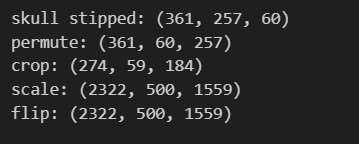

In [7]:
def plot_img(read_img_path, overlay=None, slice=None):
    if isinstance(read_img_path, str):
        img = sitk.ReadImage(read_img_path)
        
    else: # passed an already loaded img
        img = read_img_path

    print("Size:", img.GetSize())

    if slice is None:
        slice = img.GetSize()[2] // 2 # default just plot middle z slice


    img_arr = sitk.GetArrayFromImage(img)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_arr[slice, :, :], cmap="gray", alpha=1.0) 
     
    if overlay is not None:
        plt.imshow(overlay[slice, :, :], cmap="jet", alpha=0.5)

    plt.title(f"Image Display: slice {slice}")
    plt.colorbar(label="Intensity")
    plt.show()



In [8]:
# plot to debug
read_img_path = "./data/mouse/skullStripped/01sub.nii"
##def train_1_mouse_registration(read_img_path, save_img_path):

img = sitk.ReadImage(read_img_path)
print("skull stipped:", img.GetSize())
print("skull stripped cropped:", img_permute_cropped.GetSize())

mouse_atlas = sitk.ReadImage("./atlases/mouse_atlas_common_proc.nii")

atlas_array = sitk.GetArrayFromImage(img)
labels_array = sitk.GetArrayFromImage(mouse_atlas)

print("atlas:", atlas_array.shape)
print("labels:", labels_array.shape)

# Select a slice index (e.g., middle slice along the axial plane)
slice_idx = 300  # Middle slice

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(atlas_array[slice_idx, :, :], cmap="gray", alpha=1.0)  
plt.imshow(labels_array[slice_idx, :, :], cmap="jet", alpha=0.5) # overlay

plt.title(f"Overlay of Human Atlas on Labels (Slice {slice_idx})")
plt.colorbar(label="Atlas Intensity")
plt.show()

plt.figure(figsize=(8, 8))
plt.title(f"Atlas (Slice {slice_idx})")
plt.imshow(atlas_array[slice_idx, :, :], cmap="gray", alpha=1.0)  
plt.show()

plt.figure(figsize=(8, 8))
plt.title(f"Labels (Slice {slice_idx})")
plt.imshow(labels_array[slice_idx, :, :], cmap="jet", alpha=1.0)  

skull stipped: (361, 257, 60)
skull stripped cropped: (274, 396, 184)
atlas: (60, 257, 361)
labels: (541, 541, 541)


IndexError: index 300 is out of bounds for axis 0 with size 60

<Figure size 800x800 with 0 Axes>

Size: (540, 540, 540)


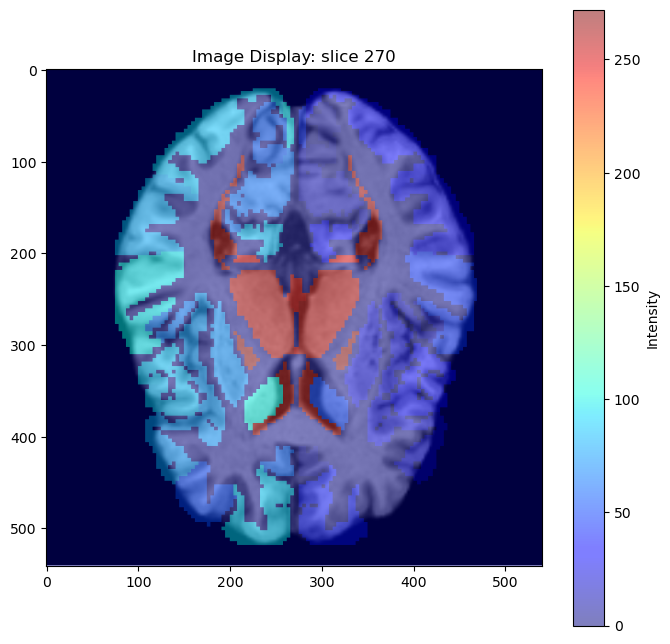

Size: (652, 652, 652)


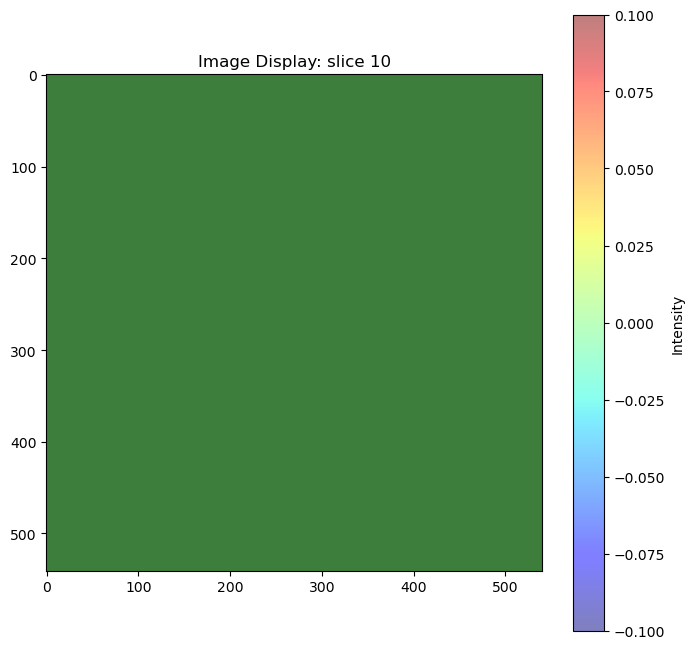

Size: (652, 652, 652)


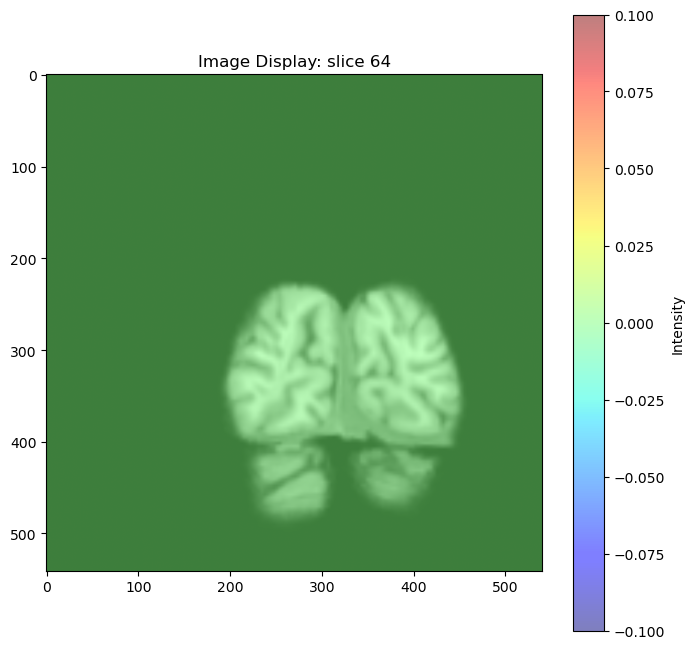

Size: (652, 652, 652)


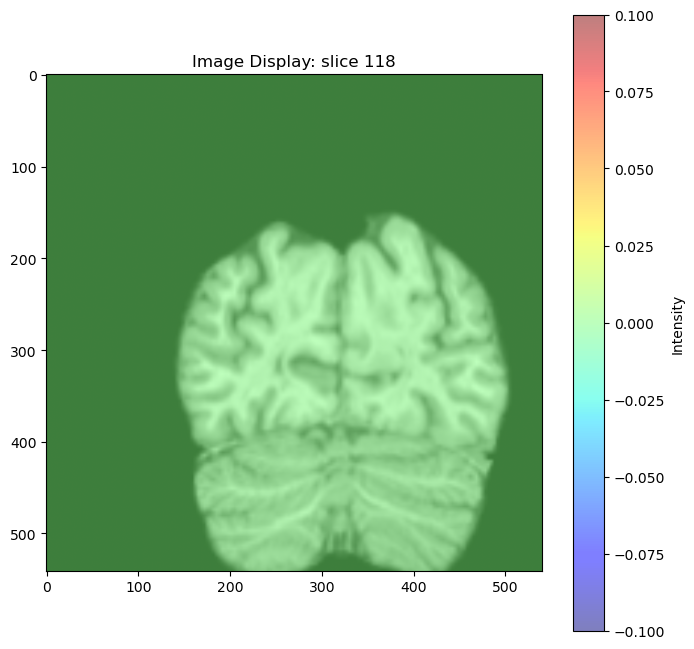

Size: (652, 652, 652)


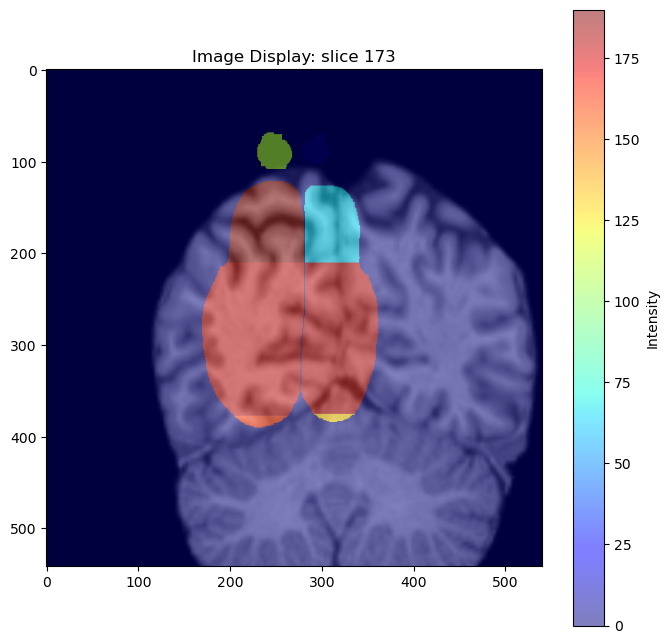

Size: (652, 652, 652)


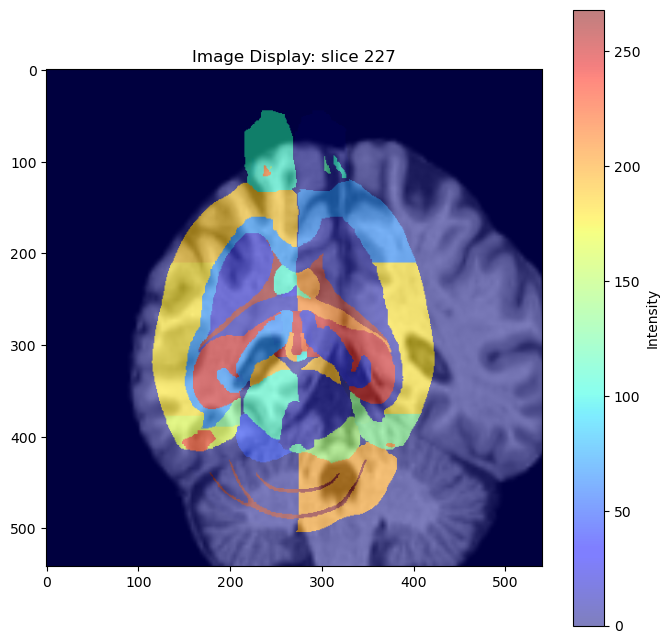

Size: (652, 652, 652)


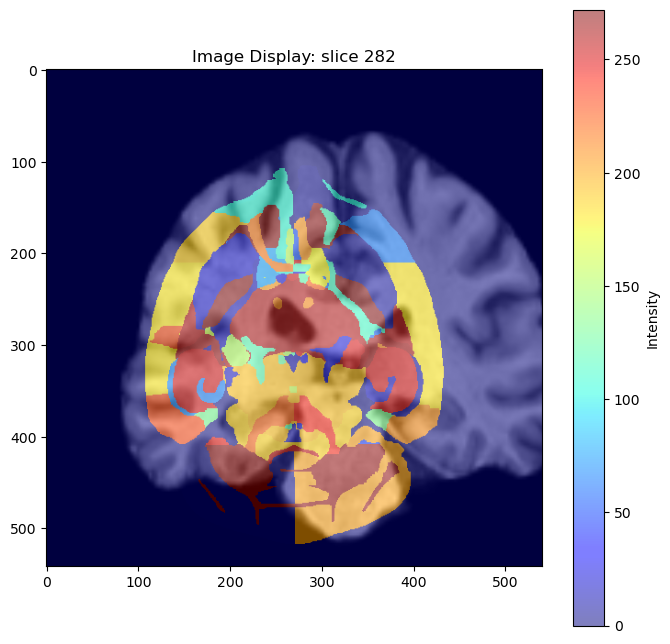

Size: (652, 652, 652)


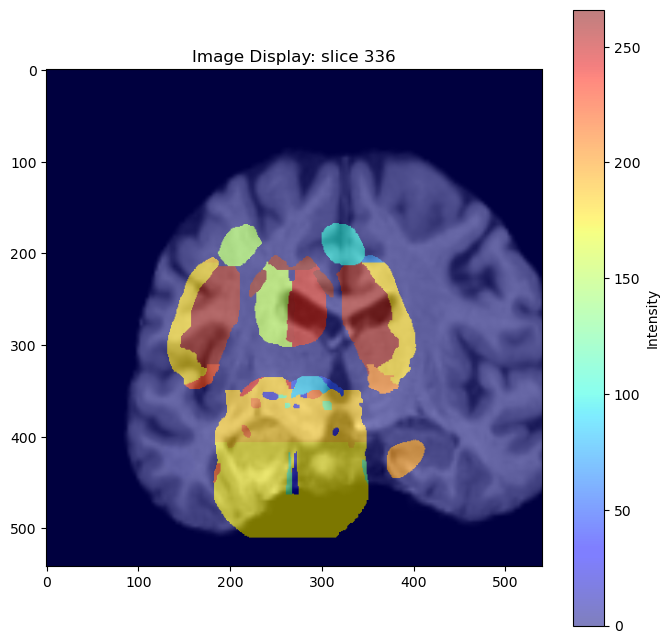

Size: (652, 652, 652)


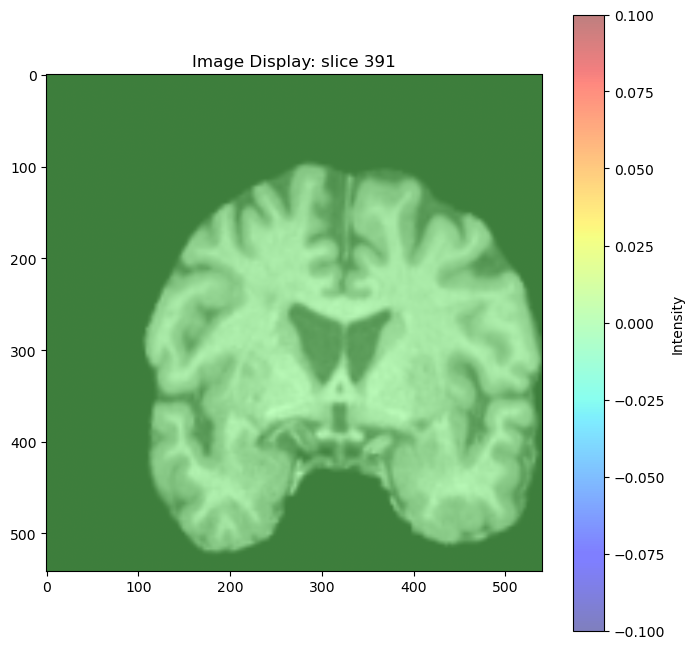

Size: (652, 652, 652)


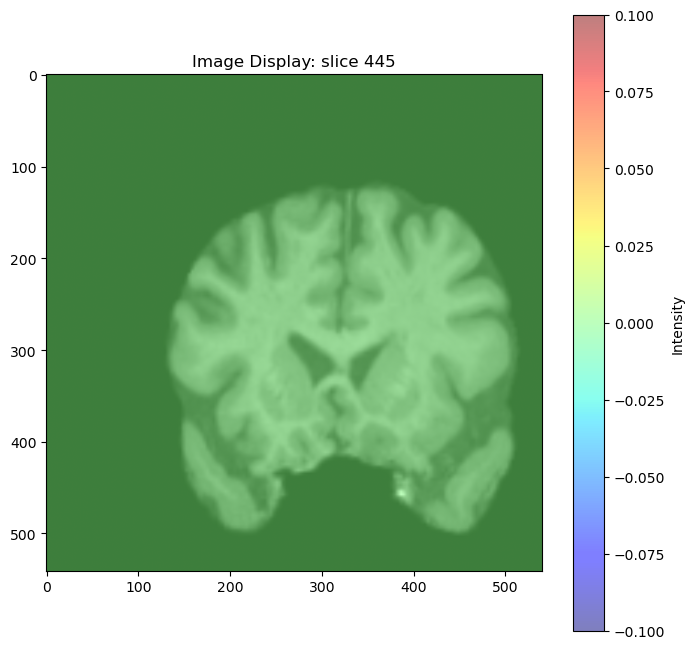

Size: (652, 652, 652)


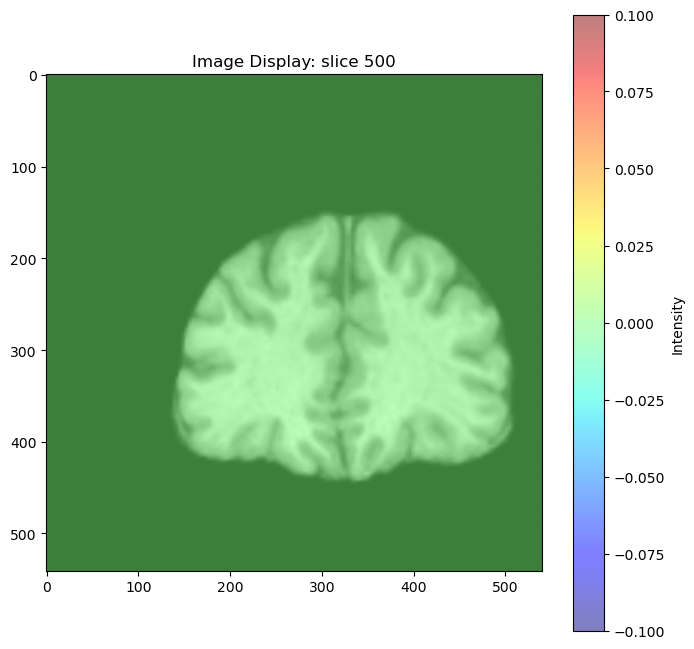

In [24]:
human_overlay = sitk.ReadImage("./atlases/human_labels_common_proc.nii")
human_overlay_arr = sitk.GetArrayFromImage(human_overlay)

plot_img("./data/human/processed/1020415.nii", human_overlay_arr)

mouse_overlay = sitk.ReadImage("./atlases/mouse_labels_common_proc.nii")
mouse_overlay_arr = sitk.GetArrayFromImage(mouse_overlay)

for i in np.linspace(10, 500, 10):
    plot_img("./data/mouse/processed/01sub.nii", mouse_overlay_arr, slice=int(i))

affine aligned
Size: (420, 282, 548)


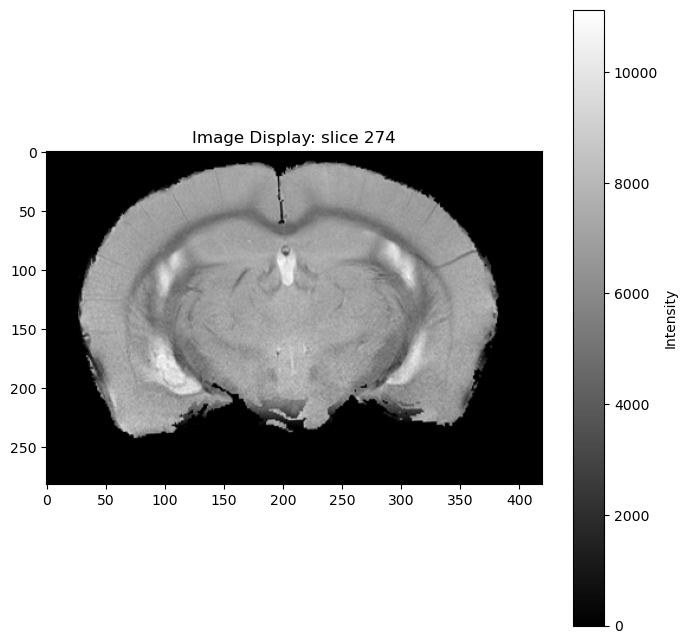

skull stripped
Size: (361, 257, 60)


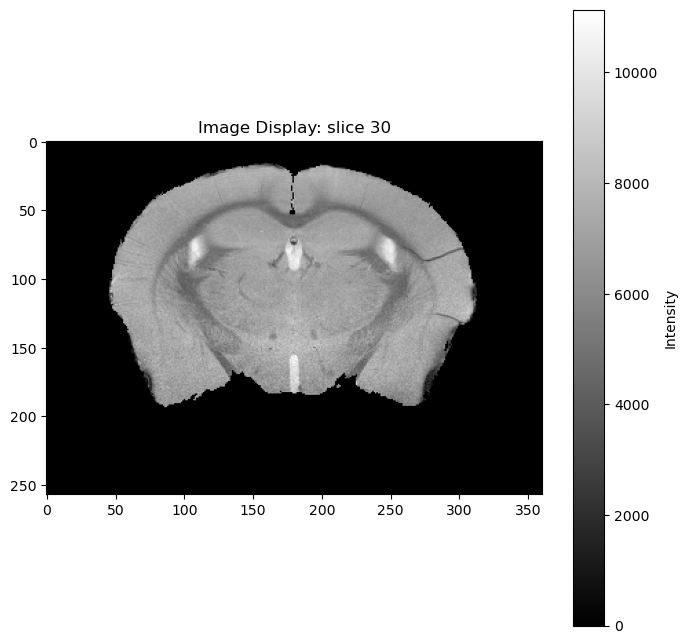

skull stripped cropped
Size: (274, 396, 184)


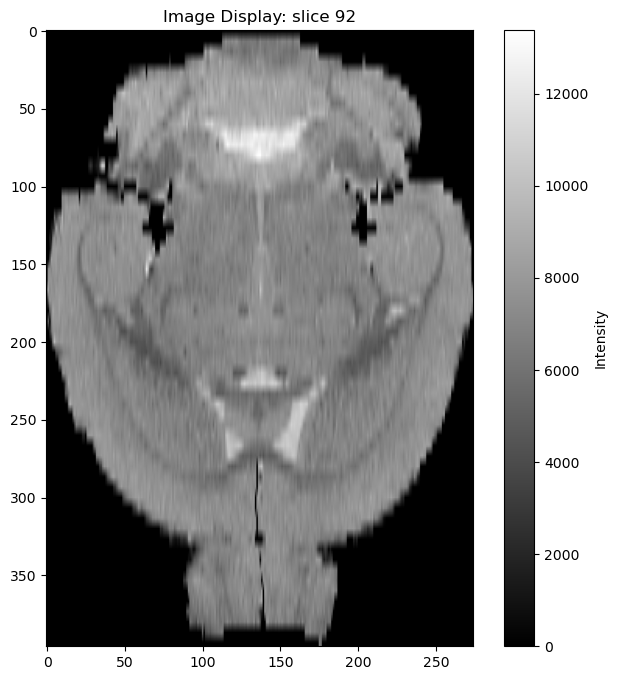

scaled cropped flipped
Size: (346, 500, 232)


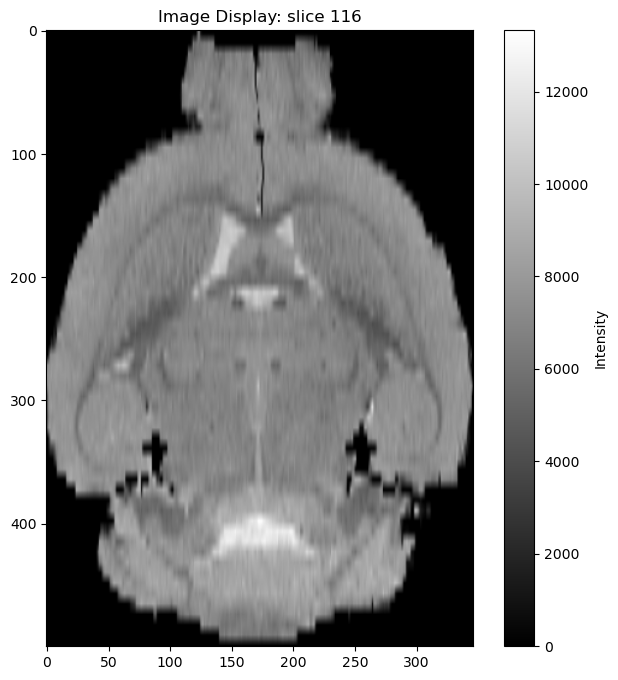

atlas
Size: (541, 541, 541)


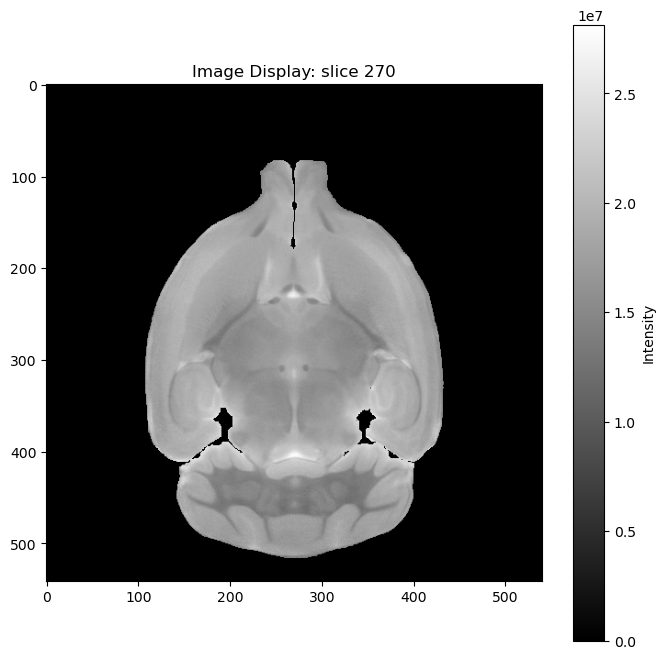

atlas cropped
Size: (324, 500, 230)


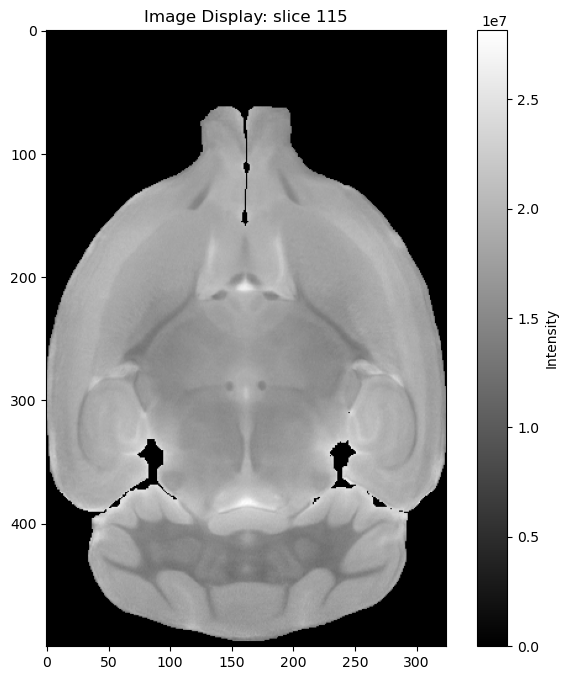

resampled to even spacing
Size: (361, 257, 400)


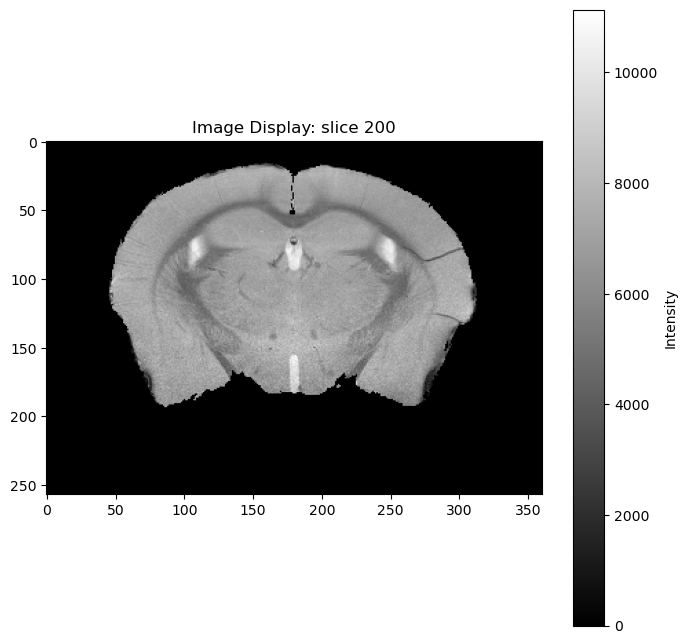

Size: (420, 282, 548)


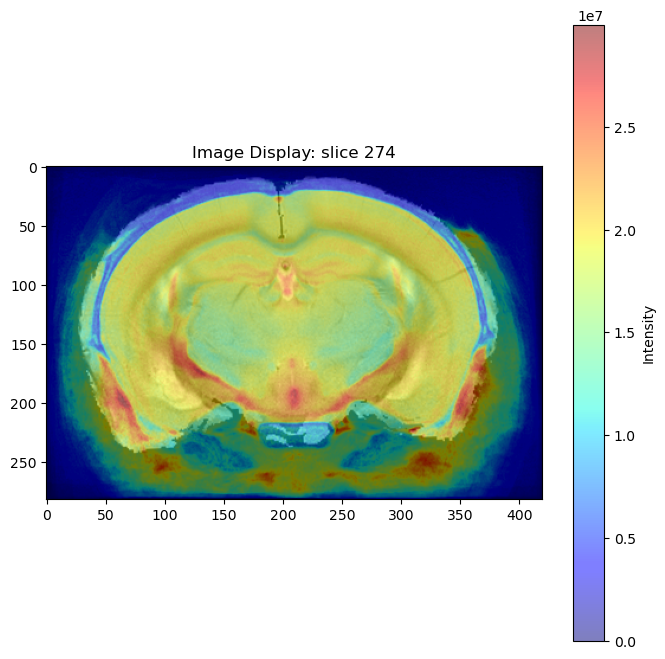

In [ ]:
img_paths = {
    "affine aligned": "./data/mouse/affine_trans/01sub.nii",
    "skull stripped": "./data/mouse/skullStripped/01sub.nii",
    "skull stripped cropped": img_permute_cropped,
    "scaled cropped flipped": img_permute_cropped_scaled_flipped,
    "atlas": "./atlases/mouse_atlas_common_proc.nii",
    "atlas cropped": mouse_atlas_cropped,
    "resampled to even spacing": "./data/mouse/skullStripped/01sub_resampled_to_even_spacing.nii",
}

overlay = sitk.ReadImage("./atlases/mouse_atlasReformat.nii")
overlay = sitk.GetArrayFromImage(overlay)


for img_path in img_paths:
    print(img_path)
    plot_img(img_paths[img_path])

affine_aligned_path = "./data/mouse/affine_trans/01sub.nii"
affine_aligned_path_img = sitk.ReadImage(affine_aligned_path)

# to align with the new atlas??
affine_aligned_path_img_permute = sitk.PermuteAxes(affine_aligned_path_img, [0, 2, 1])
affine_aligned_path_img_permute_flip = sitk.Flip(affine_aligned_path_img_permute, [True, True, False])

plot_img(affine_aligned_path_img, overlay)

# plot_img("./data/mouse/01sub_manual_reg.nii", overlay)
# plot_img("./data/mouse/01sub_manual_reg_resample_to_even.nii", overlay)
